[这里有完整的教程](https://harishnarayanan.org/writing/artistic-style-transfer/)

In [213]:
import time
from PIL import Image
import numpy as np
import cv2

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt

### 展示原始图像和目标图像

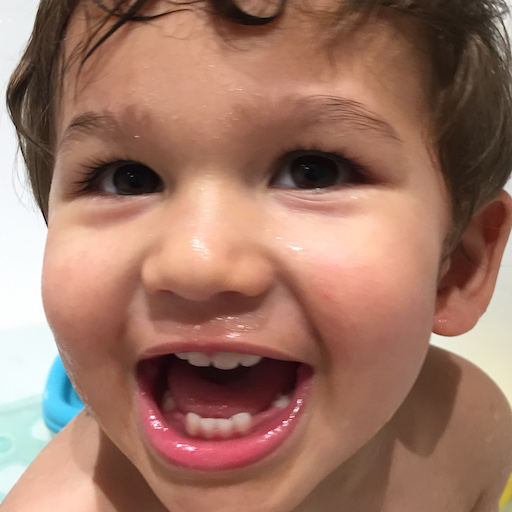

In [214]:
height = 512
width = 512

content_image_path = 'images/hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

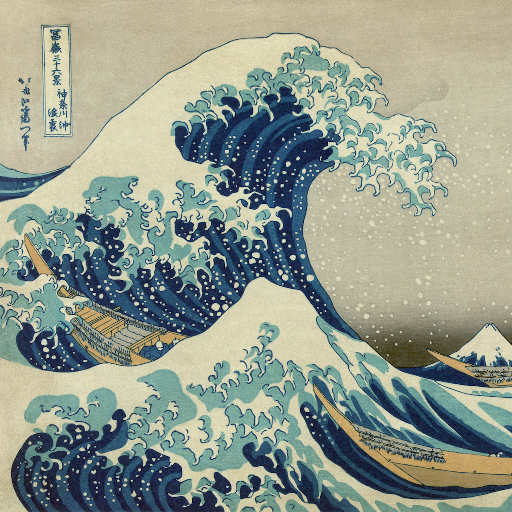

In [215]:
style_image_path = 'images/styles/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height,width))
style_image

### 转化为np结构，并且添加坐标轴

In [216]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to massage this input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduces the *VGG Network* model that we're going to use shortly.

For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [217]:
content_array[:,:,:,0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

声明变量

In [218]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1,height, width,3))

组合变量，喂给VGG16

In [219]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image],
                                    axis=0)

使用预训练的VGG16

## Reuse a model pre-trained for image classification to define loss functions

The core idea introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the *feature spaces* provided by one such model to independently work with content and style of images.

The original paper uses the 19 layer VGG network model from [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), but we're going to instead follow [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) and use the 16 layer model (VGG16). There is no noticeable qualitative difference in making this choice, and we gain a tiny bit in speed.

Also, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the part of the model marked in green in the table below.

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

In [220]:
model = VGG16(input_tensor=input_tensor,
              weights='imagenet',
              include_top=False)

keras对每一层都有自己的命名

In [221]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_10/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_10/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_10/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_10/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_10/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_10/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_10/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_10/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_10/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_10/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_10/Relu:0' shape=(3,

上个输出表示我们拿到了所有层，而且我们给网络喂的是组合起来的数据，所以输出使第一个维度是3

此部分代码复现的论文地址是 [style transfer problem can be posed as an optimisation problem](https://harishnarayanan.org/writing/artistic-style-transfer/), 这里损失函数被分解为三个独立的部分: the *content loss*, the *style loss* and the *total variation loss*.

下面的权重分配是经过大量验证的

In [222]:
layers['block1_conv1'].shape[1].value

512

In [223]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

现在我们将使用由我们的模型的特定层提供的特征空间来定义这三个损失函数。我们首先将总损失初始化为0，并逐步增加。

In [224]:
loss = backend.variable(0.)

### The content loss

For the content loss, we follow Johnson et al. (2016) and draw the content feature from `block2_conv2`, because the original choice in Gatys et al. (2015) (`block4_conv2`) loses too much structural detail. And at least for faces, I find it more aesthetically pleasing to closely retain the structure of the original content image.

This variation across layers is shown for a couple of examples in the images below (just mentally replace `reluX_Y` with our Keras notation `blockX_convY`).

![Content feature reconstruction](images/content-feature.png "Content feature reconstruction")

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [225]:
def content_loss(content, combination):
    # 内容差就是对应隐藏层的平方差之和
    return backend.sum(backend.square(combination-content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]

loss += content_weight * content_loss(content_image_features, combination_features)

### The style loss

This is where things start to get a bit intricate.

For the style loss, we first define something called a *Gram matrix*. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. (This is not trivial at all, and I refer you to [a paper that attempts to explain the idea](https://arxiv.org/abs/1606.01286).)

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

下面的函数定义了gram matrix。具体思想是，对于某个隐藏层，计算其每一个图层之间的相关性，计算方法就是协方差矩阵，再计算该矩阵的平方和

In [226]:
def gram_matrix(x):
    # 先进行了轴的转置。因为是计算层与层之间的协方差矩阵，所以把深度轴提取出来
    # 又因为最后计算的是平方和，所以直接flatten方便后续计算
    features = backend.batch_flatten(backend.permute_dimensions(x, (2,0,1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [227]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
#     ten_shape = style.shape
#     channels = ten_shape[2].value
#     size = ten_shape[0].value * ten_shape[1].value
#     后面缩小是为了归一化
    return backend.sum(backend.square(S-C))/(4. * (channels**2) * (size**2))
feature_layers = ['block1_conv2',
                 'block2_conv2',
                 'block3_conv3',
                 'block4_conv3',
                 'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

## total variation loss

总变分，用来处理噪音问题，如果只使用前面两个loss，会导致图像噪音过大

In [228]:
def total_variation_loss(x):
    a = backend.square(x[:, :-1, :-1, :] - x[:,1:,:-1,:])
    b = backend.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return backend.sum(backend.pow(a+b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

定义梯度

## Define needed gradients and solve the optimisation problem

[The goal of this journey](https://harishnarayanan.org/writing/artistic-style-transfer/) was to setup an optimisation problem that aims to solve for a *combination image* that contains the content of the content image, while having the style of the style image. Now that we have our input images massaged and our loss function calculators in place, all we have left to do is define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

We start by defining the gradients.

In [229]:
grads = backend.gradients(loss, combination_image)
print(grads)

[<tf.Tensor 'gradients_11/AddN_15:0' shape=(1, 512, 512, 3) dtype=float32>]


接下来实现一个Evaluator类，可以一次计算loss和gradients， 这么做是因为scipy.optimize需要独立的函数来计算loss和gradients，但是分开计算效率太低了

In [230]:
# 把loss和grads放入一个list
outputs = [loss]
outputs += grads
# 建立从combination_image到outputs的映射函数，以便一次计算出两个值
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1,height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

# 一次计算得到loss和 grads两个值
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_valeus = None
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

Start of iteration 0
Current loss value: 78610740000.0
Iteration 0 completed in 3s


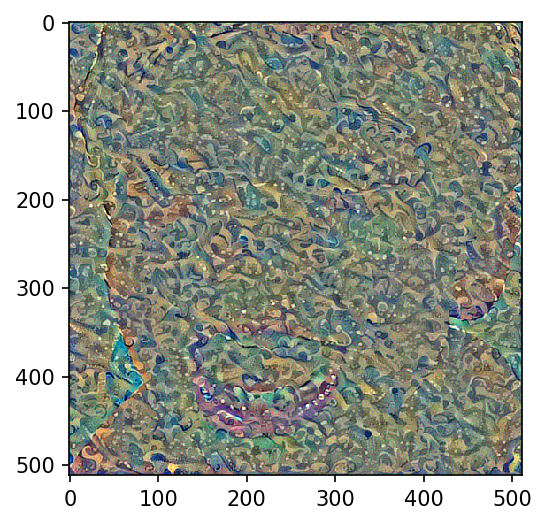

Start of iteration 1
Current loss value: 54743294000.0
Iteration 1 completed in 3s


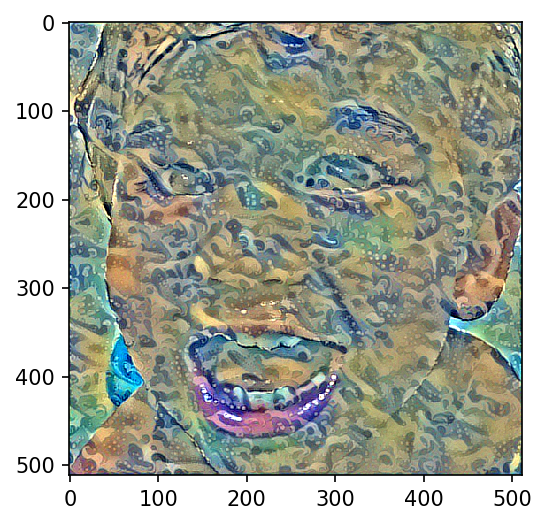

Start of iteration 2
Current loss value: 44382150000.0
Iteration 2 completed in 3s


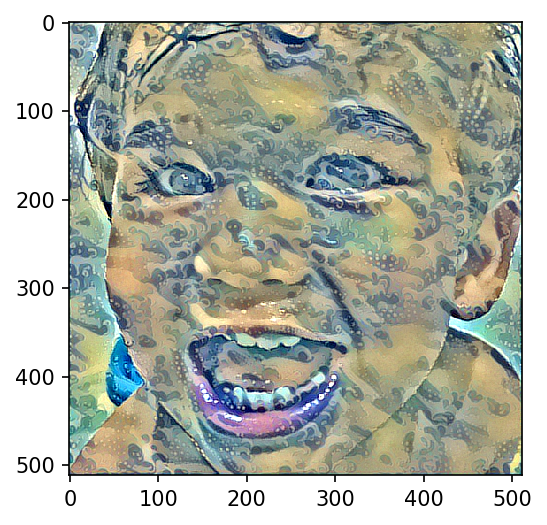

Start of iteration 3
Current loss value: 40365030000.0
Iteration 3 completed in 3s


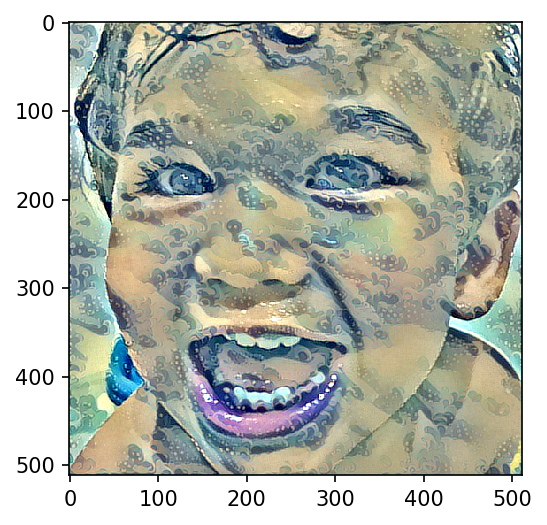

Start of iteration 4
Current loss value: 38572175000.0
Iteration 4 completed in 3s


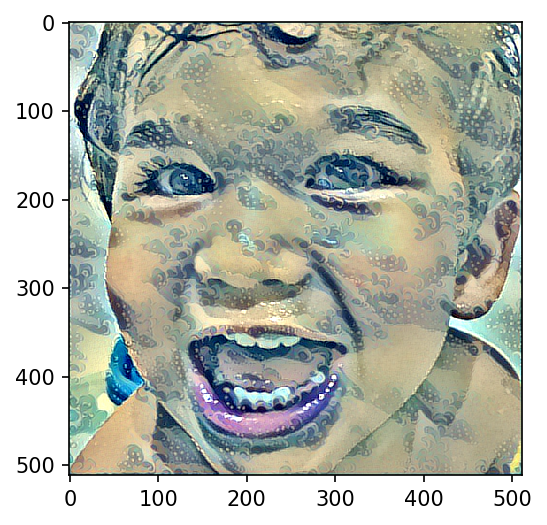

Start of iteration 5
Current loss value: 37456510000.0
Iteration 5 completed in 3s


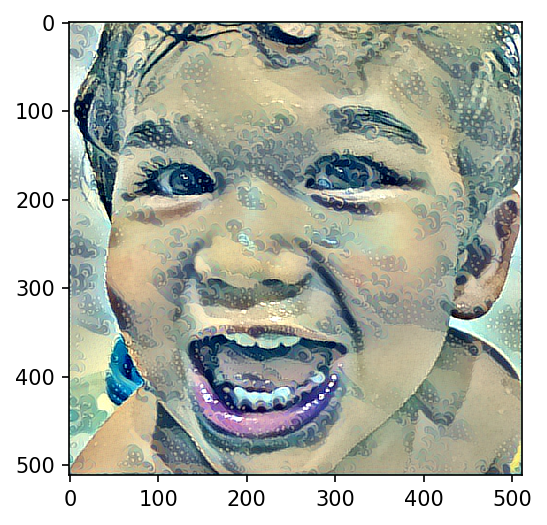

Start of iteration 6
Current loss value: 36803252000.0
Iteration 6 completed in 3s


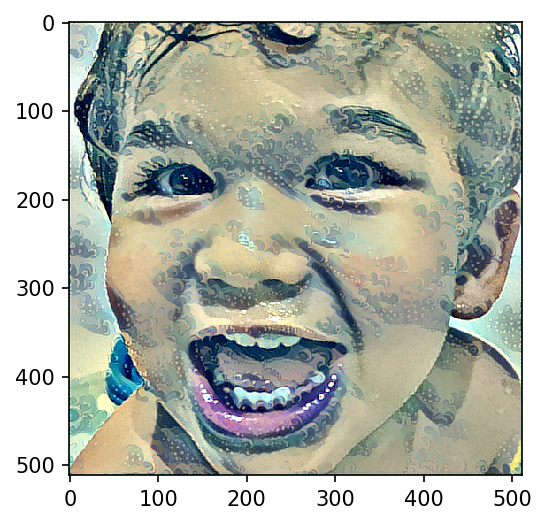

Start of iteration 7
Current loss value: 36337820000.0
Iteration 7 completed in 3s


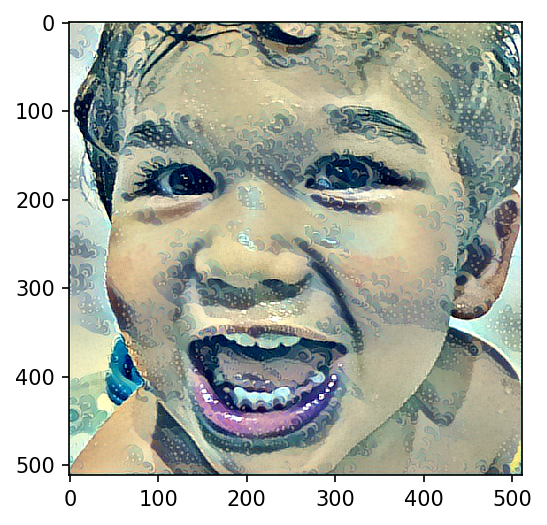

Start of iteration 8
Current loss value: 36044450000.0
Iteration 8 completed in 4s


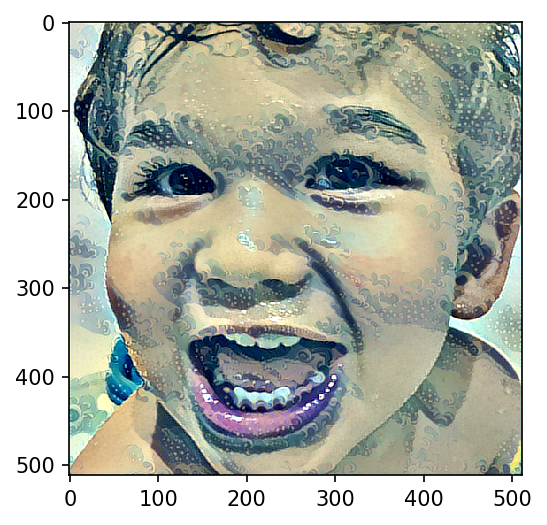

Start of iteration 9
Current loss value: 35825496000.0
Iteration 9 completed in 3s


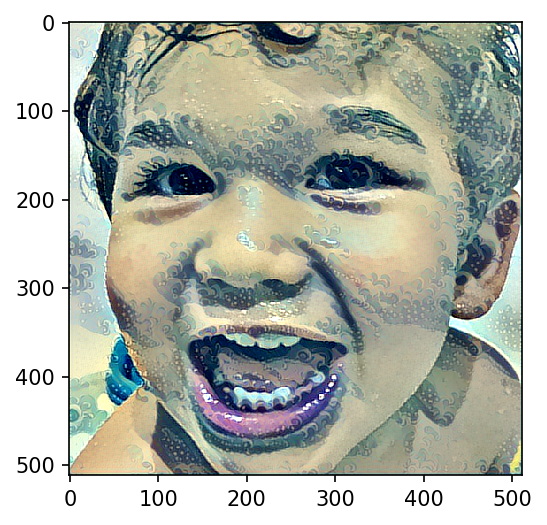

Start of iteration 10
Current loss value: 35687137000.0
Iteration 10 completed in 3s


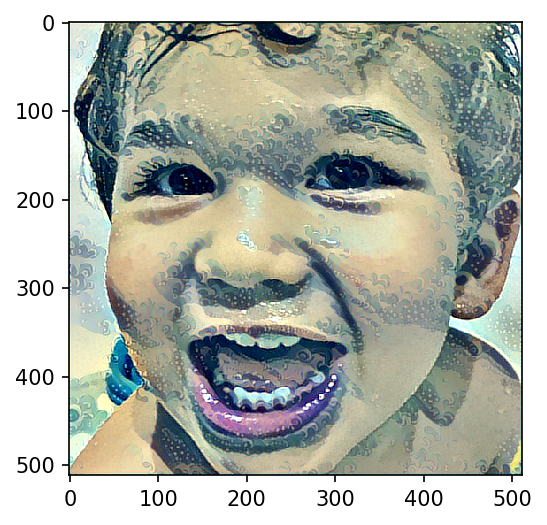

Start of iteration 11
Current loss value: 35587486000.0
Iteration 11 completed in 3s


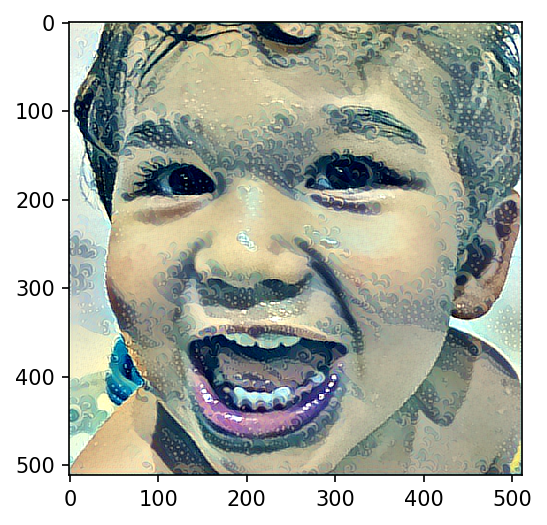

In [232]:
x = np.random.uniform(0,255,(1,height, width, 3)) - 128
iterations = 12

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                    fprime=evaluator.grads,maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds'%(i, end_time-start_time))
    
    show1 = x.copy().reshape((height, width, 3))
    show1 = show1[:, :, ::-1]
    show1[:, :, 0] += 103.939
    show1[:, :, 1] += 116.779
    show1[:, :, 2] += 123.68
    show1 = np.clip(show1, 0, 255).astype('uint8')
#     show1 = cv2.resize(show1,(int(2240/4),int(3968/4)))

    fig = plt.figure(dpi=150)
    plt.imshow(show1)
    plt.show()